DATA PREPARATION

### 01 — Start: Tooling and imports

We begin by assembling the toolbox required for the experiment: numerical libraries, plotting utilities, the deep-learning stack, and SHAP for explanations. Think of this as unpacking the lab equipment before the experiment begins.

In [1]:
!pip install shap
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import tensorflow as tf
import shap
# from google.colab import drive
import math
import random

You should consider upgrading via the 'C:\Users\Admin\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


### 02 — Loading raw cycles

This cell reads the raw .mat battery cycles into memory. It pulls voltage, current and temperature traces from disk so subsequent steps can shape them into model inputs.

In [2]:
file_path = 'batch3.pkl'

with open(file_path, 'rb') as file:
    data = pickle.load(file)

### 03 — Visual checkpoint

This plotting cell transforms numbers into the figures similar to those shown in the paper (see Fig. 4–8). Inspect these plots to spot when temperature or voltage events line up with negative SHAP spikes.

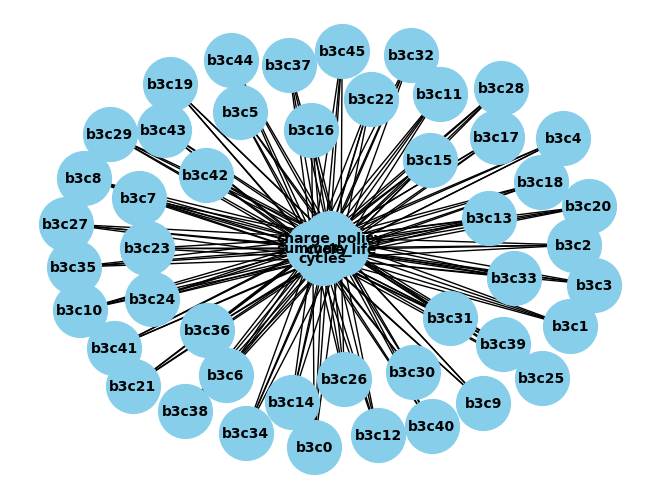

In [230]:
import matplotlib.pyplot as plt
import networkx as nx



# Create a graph from the tree data
G = nx.Graph(data)

# Define the layout
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=1500, node_color='skyblue', font_size=10, font_weight='bold')

# Show the plot
plt.show()


### 04 — Support step

A conversion step preparing arrays for plotting and aggregation.

In [77]:
# choosing the cell with the minimum number of cycles
min_nb_cycles = 100000
max_nb_cycles = 0
batt_max = ''
batt_min = ''
for b in data_keys:
    if math.isnan(data[b]['cycle_life'][0][0]):
            continue
    if len(data[b]['cycles']) < min_nb_cycles:
        min_nb_cycles = len(data[b]['cycles'])
        batt_min = b
    if len(data[b]['cycles']) > max_nb_cycles:
        max_nb_cycles = len(data[b]['cycles'])
        batt_max = b

new_battery_min = [batt_min]
new_battery_max = [batt_max]

### 05 — Support step

A targeted transformation aligning sample indices across windows.

In [4]:
# choose randomly validating battery
# new_battery_list = data_keys[random.randint(0, 44)]
new_battery_list = data_keys[19]
battery_list = [x for x in data_keys if (x != new_battery_list) and (x != new_battery_max) and (x != new_battery_min) ]
new_battery_list = [new_battery_list]

### 06 — Downsampling narrative

Raw sensor traces are dense and noisy; here we reduce temporal resolution to keep the cycle dynamics readable and the training affordable — preserving shape while trimming excess detail.

In [6]:
# Sampling data of one cycle to 200 points
def downsample_data(battery, cycle, feature):
    original_data = data[battery]['cycles'][str(cycle)][feature]

    segment_size = len(original_data) // 200

    # Reshape the data into a 2D array with 200 rows
    reshaped_data = np.reshape(original_data[:200 * segment_size], (200, segment_size))

    # Calculate the mean along the columns to downsample to 200 points
    downsampled_data = np.mean(reshaped_data, axis=1)

    return downsampled_data

### 07 — Downsampling narrative

Raw sensor traces are dense and noisy; here we reduce temporal resolution to keep the cycle dynamics readable and the training affordable — preserving shape while trimming excess detail.

In [298]:
def plotData(battery, first_cycle, nb_cycles, feature, y_label, ax, sampling=False):
    cycles = []
    for i in range(nb_cycles):
        if sampling:
            d = downsample_data(battery, first_cycle+i, feature)
            cycles.append(pd.Series(d))
        else:
            cycles.append(pd.Series(data[battery]['cycles'][str(first_cycle+i)][feature]))

    # Concatenate the data from the cycles
    concatenated_data = pd.concat(cycles)

    # Reset the index if needed
    concatenated_data = concatenated_data.reset_index(drop=True)

    # Plot the concatenated data on the given axis
    if sampling:
        ax.scatter(range(len(concatenated_data)), concatenated_data, s=10)  # s is the size of the markers
    else:
        ax.plot(concatenated_data)

    ax.set_xlabel('Time (t)')
    ax.set_ylabel(y_label)
    ax.set_title(f'{y_label[:-4]} {"(with sampling)" if sampling else "(without sampling)"}')


### 08 — Downsampling narrative

Raw sensor traces are dense and noisy; here we reduce temporal resolution to keep the cycle dynamics readable and the training affordable — preserving shape while trimming excess detail.

In [299]:
def plotAllData(new_battery_list, first_cycle, nb_cycles):
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    features = [('I', 'Current (I)'), ('T', 'Temperature (T)'), ('V', 'Voltage (V)')]

    for i, (feature, y_label) in enumerate(features):
        plotData(new_battery_list[0], first_cycle, nb_cycles, feature, y_label, axs[i, 0], sampling=False)
        plotData(new_battery_list[0], first_cycle, nb_cycles, feature, y_label, axs[i, 1], sampling=True)

    plt.tight_layout()
    plt.show()

### 09 — Support step

A small debugging or inspection step — useful during development.

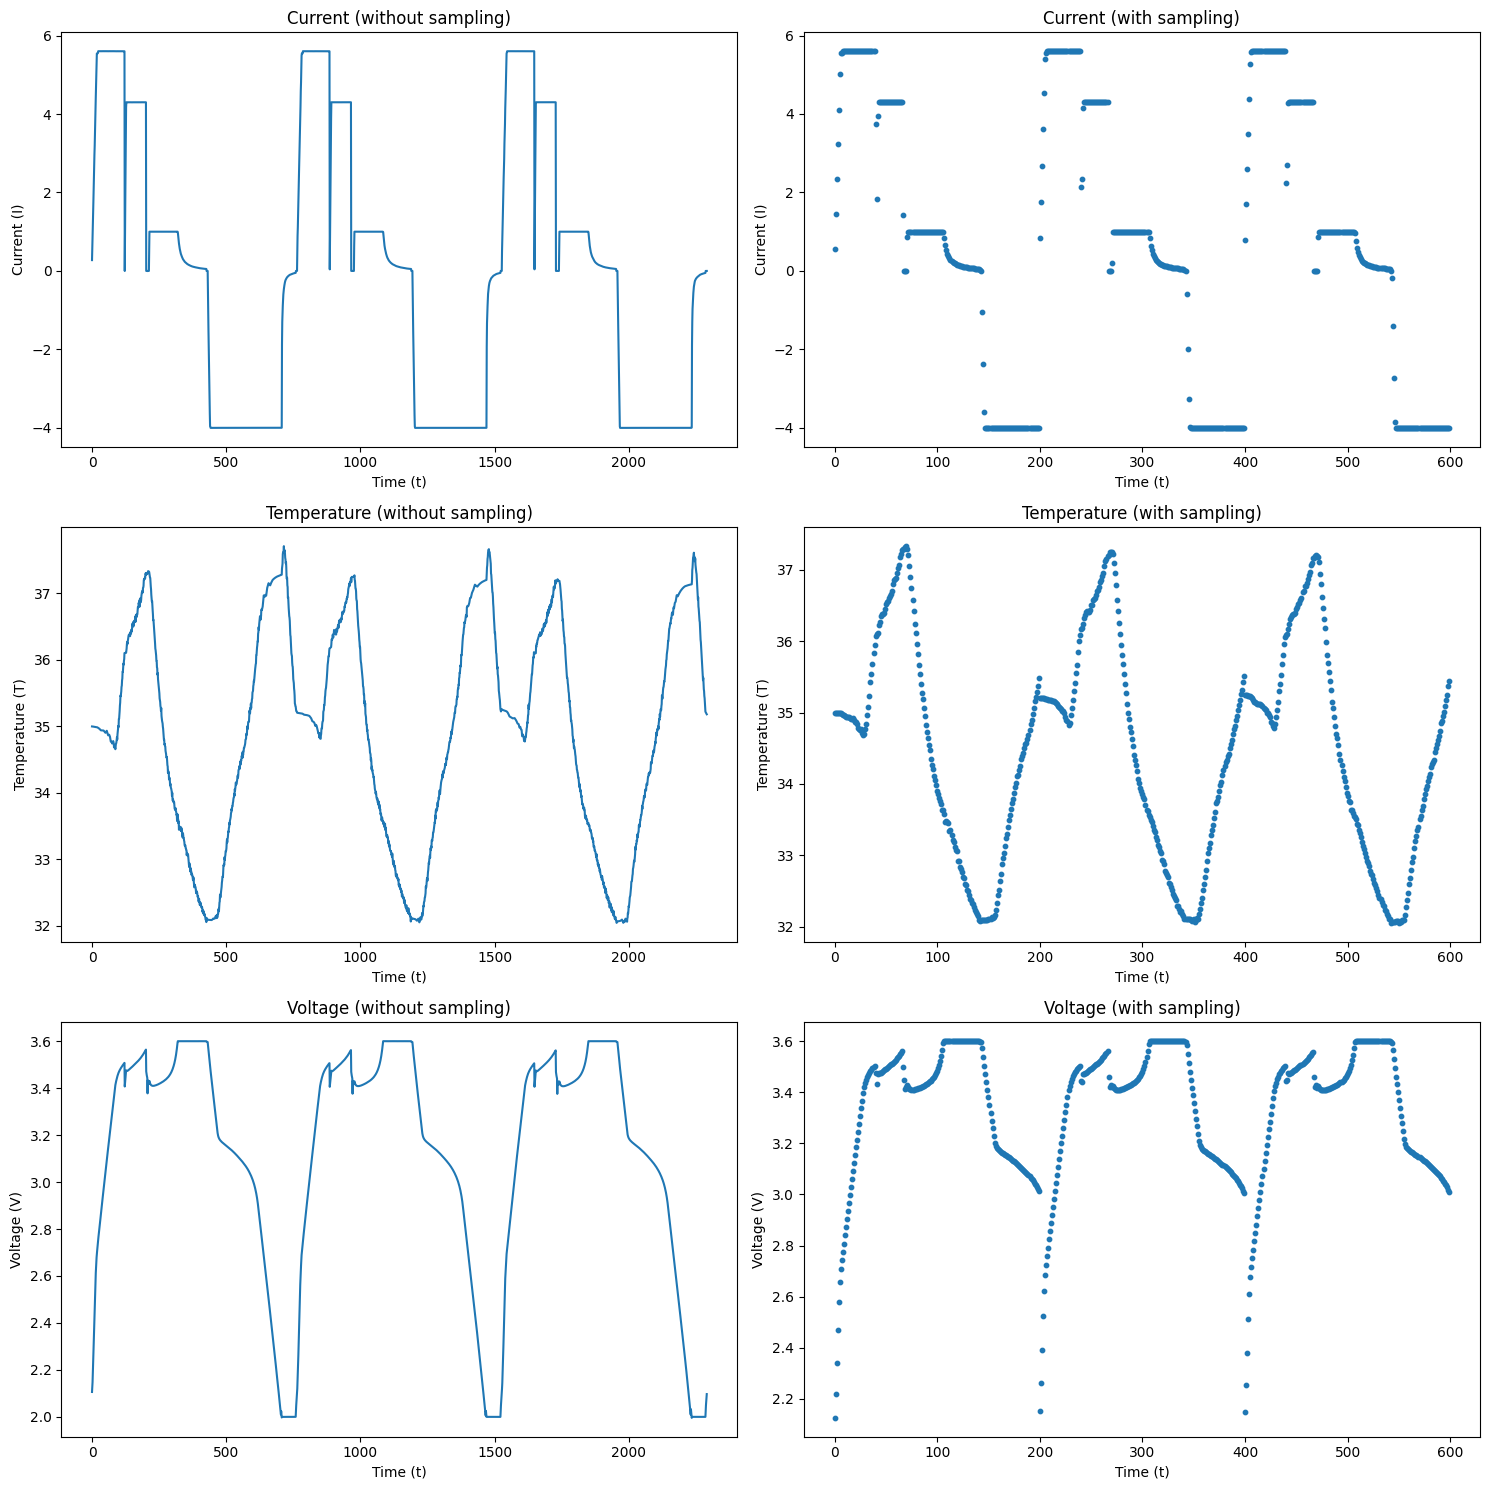

In [300]:
plotAllData(new_battery_list, 0, 3)

### 010 — Downsampling narrative

Raw sensor traces are dense and noisy; here we reduce temporal resolution to keep the cycle dynamics readable and the training affordable — preserving shape while trimming excess detail.

In [11]:
def collectData(b_list):
    sliced_data = []
    for battery in b_list:
        if math.isnan(data[battery]['cycle_life'][0][0]):
            continue
        for cycle in range(3, int(data[battery]['cycle_life'][0][0]) - 1):
            sliced_data.append({
                'I': np.concatenate([downsample_data(battery, cycle - 2, 'I'), downsample_data(battery, cycle - 1, 'I'),
                                     downsample_data(battery, cycle, 'I')]),
                'T': np.concatenate([downsample_data(battery, cycle - 2, 'T'), downsample_data(battery, cycle - 1, 'T'),
                                     downsample_data(battery, cycle, 'T')]),
                'V': np.concatenate([downsample_data(battery, cycle - 2, 'V'), downsample_data(battery, cycle - 1, 'V'),
                                     downsample_data(battery, cycle, 'V')]),
                'QD': data[battery]['summary']['QD'][cycle],
                'SOH': data[battery]['summary']['QD'][cycle] / data[battery]['summary']['QD'][0]
            })
    return sliced_data

### 011 — Support step

A targeted transformation aligning sample indices across windows.

In [12]:
collected_data = collectData(battery_list)
collected_data[0]

{'I': array([ 7.29777021e-01,  1.66644358e+00,  2.58346558e+00,  3.46804764e+00,
         4.42072552e+00,  4.95564548e+00,  5.00474873e+00,  5.00402970e+00,
         5.00259630e+00,  5.00203336e+00,  5.00192700e+00,  5.00193397e+00,
         5.00216400e+00,  5.00193161e+00,  5.00248418e+00,  5.00248767e+00,
         5.00230270e+00,  5.00215821e+00,  5.00248767e+00,  5.00160103e+00,
         5.00044273e+00,  5.00090397e+00,  5.00038376e+00,  5.00043812e+00,
         5.00020115e+00,  5.00035718e+00,  5.00046933e+00,  5.00070167e+00,
         5.00040806e+00,  5.00015836e+00,  5.00032945e+00,  5.00053636e+00,
         5.00052482e+00,  4.99990867e+00,  5.00017339e+00,  5.00000809e+00,
         5.00002773e+00,  5.00037685e+00,  5.00017921e+00,  5.00029361e+00,
         4.99991679e+00,  5.00001733e+00,  4.99968788e+00,  4.99964397e+00,
         4.99913648e+00,  4.99891342e+00,  4.99884170e+00,  4.99896309e+00,
         4.99920121e+00,  4.99935730e+00,  4.99971679e+00,  4.99883594e+00,
       

### 012 — Scaling the story

To make features comparable, this step rescales current, temperature and voltage into the same numeric range. This is essential so the CNN learns patterns rather than numeric magnitudes.

In [14]:
def findMinMaxValues(data_to_process):
    # min max normalization algorithm for the data
    min_values = {'I': float('inf'), 'T': float('inf'), 'V': float('inf')}
    max_values = {'I': float('-inf'), 'T': float('-inf'), 'V': float('-inf')}


    for cycle in range (0, len(data_to_process)):
        for key in min_values:
            min_values[key] = min(min_values[key], min(data_to_process[cycle][key]))
            max_values[key] = max(max_values[key], max(data_to_process[cycle][key]))

    return min_values, max_values

### 013 — Scaling the story

To make features comparable, this step rescales current, temperature and voltage into the same numeric range. This is essential so the CNN learns patterns rather than numeric magnitudes.

In [15]:
def minMaxNormalization(data_to_process, min_values, max_values):


    # Perform min-max normalization on each array in the sliced data
    for cycle in range (0, len(data_to_process)):
        for key in min_values:
              data_to_process[cycle][key] = [(val - min_values[key]) / (max_values[key] - min_values[key])
                                                    for val in data_to_process[cycle][key]]

    return data_to_process


### 014 — Scaling the story

To make features comparable, this step rescales current, temperature and voltage into the same numeric range. This is essential so the CNN learns patterns rather than numeric magnitudes.

In [16]:
min_feature_values, max_feature_values = findMinMaxValues(collected_data)
normalized_data = minMaxNormalization(collected_data, min_feature_values, max_feature_values)


### 015 — Support step

A small debugging or inspection step — useful during development.

In [17]:
def prepareData(norm_data):
    df = pd.DataFrame(norm_data)
    X = df[['I', 'T', 'V']]
    y = df[['SOH']]

    # Convert pandas DataFrames to NumPy arrays
    X_array = np.array([np.array(x) for x in X['I']])
    X_array = np.stack((X_array, np.array([np.array(x) for x in X['T']]), np.array([np.array(x) for x in X['V']])), axis=-1)
    y_array = np.array(y['SOH'])

    return X_array, y_array

### 016 — Scaling the story

To make features comparable, this step rescales current, temperature and voltage into the same numeric range. This is essential so the CNN learns patterns rather than numeric magnitudes.

In [18]:
X_array, y_array = prepareData(normalized_data)

### 017 — Visual checkpoint

This plotting cell transforms numbers into the figures similar to those shown in the paper (see Fig. 4–8). Inspect these plots to spot when temperature or voltage events line up with negative SHAP spikes.

In [197]:
def plot_input_instance(input):
    title = 'SHAP values'
    mesure = ['Tension (V)','Current (A)','Temperature (C)']
    plt.figure()
    for j in range(3):
        Value = input[:,j]
        ax = plt.subplot(3,1,j+1)
        plt.ylabel(mesure[j])
        # print(heat_j)
        plt.scatter(range(600),Value)
    plt.colorbar(orientation="horizontal")
    plt.suptitle(title,fontsize=16)
    plt.show()

### 018 — Support step

A housekeeping operation ensuring array lengths match across results.

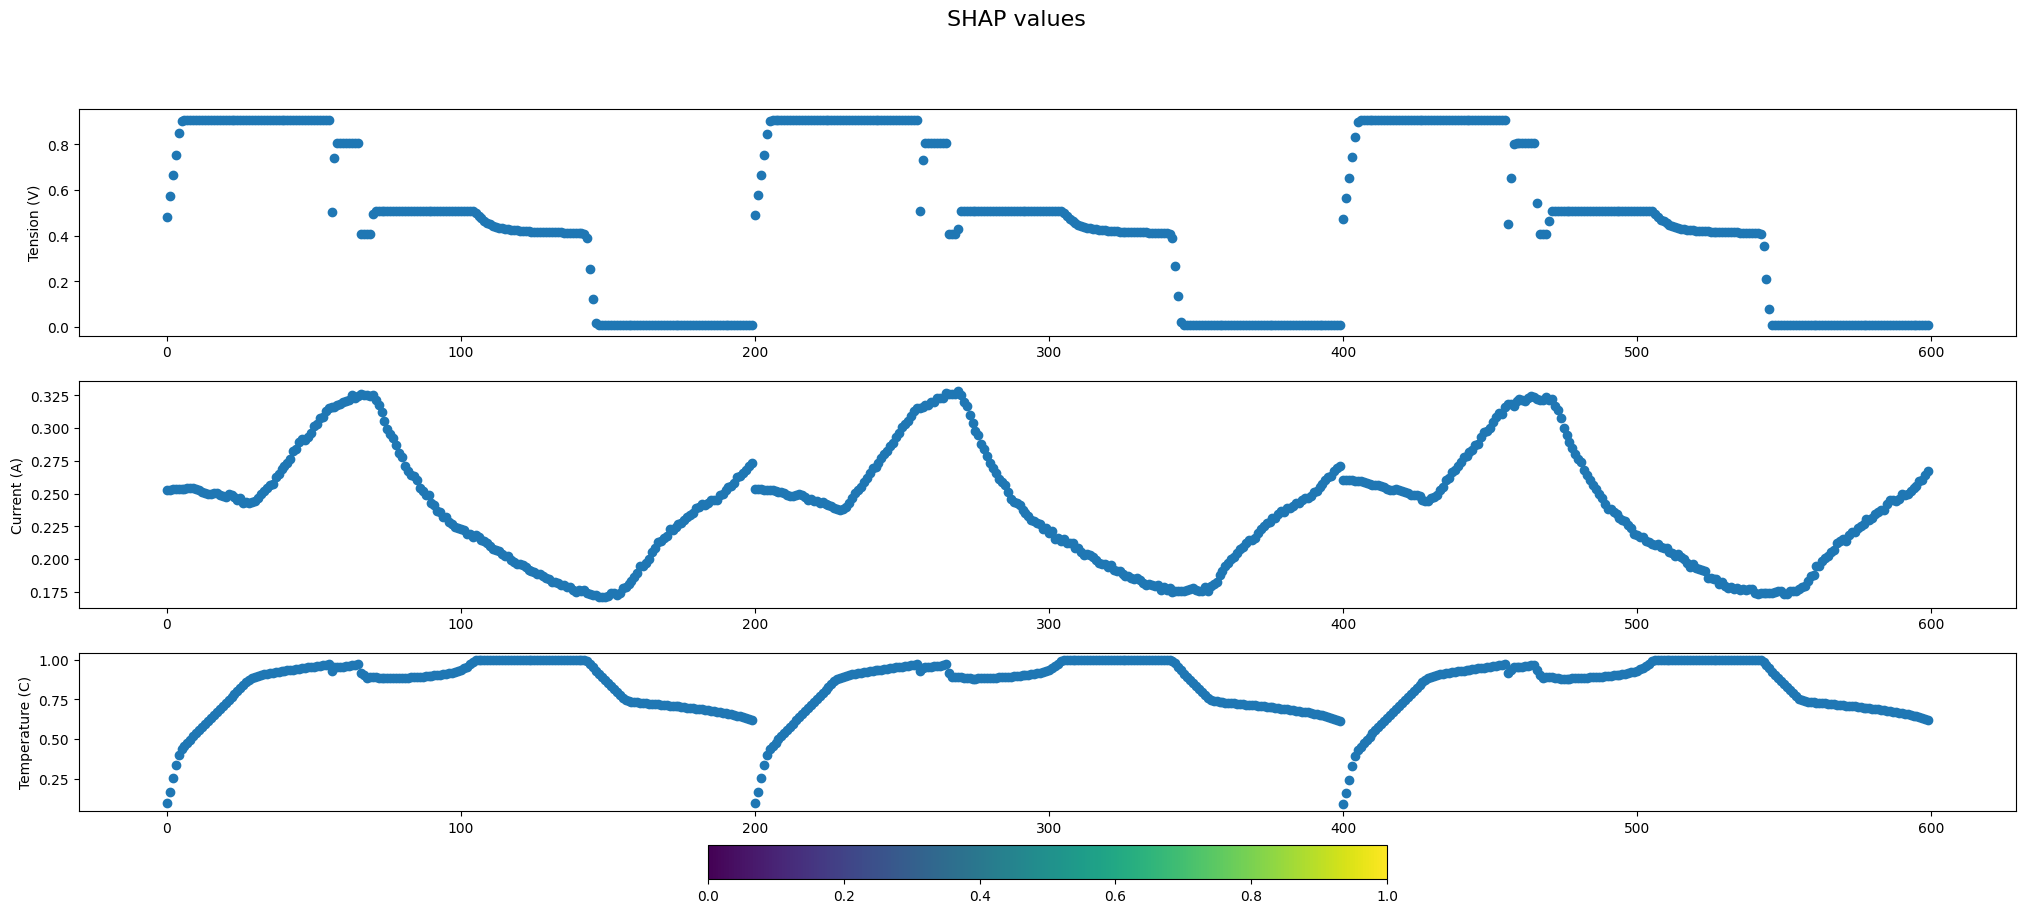

In [198]:
plot_input_instance(X_array[0])

CNN MODEL

### 019 — Support step

A quick calculation that supports the subsequent explanation steps.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

### 020 — Model architecture snapshot

This cell defines the CNN used to map multi-channel time-series to SoH. Filters will scan temporal patterns; dense layers will combine them into a health estimate.

In [22]:
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.callbacks import EarlyStopping

# Define the input layer
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Use the best hyperparameters obtained from the tuner
filters = 64
units = 60
learning_rate = 0.0001

# Build the CNN layers
conv1 = Conv1D(filters=filters, kernel_size=2, activation='relu')(input_layer)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
flatten = Flatten()(max_pool1)
dense1 = Dense(units=units, activation='relu')(flatten)
output_layer = Dense(1)(dense1)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Use the best learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model
history1 = model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_val, y_val)

# Make predictions
Y_pred = model.predict(X_val)

# Calculate evaluation metrics
mae = mean_absolute_error(y_val, Y_pred)
mse = mean_squared_error(y_val, Y_pred)

print("Test Loss:", loss)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)


Epoch 1/50
567/567 [==============================] - 18s 29ms/step - loss: 0.0042 - mae: 0.0252 - val_loss: 1.3683e-04 - val_mae: 0.0083
Epoch 2/50
567/567 [==============================] - 15s 27ms/step - loss: 1.0442e-04 - mae: 0.0074 - val_loss: 1.4217e-04 - val_mae: 0.0097
Epoch 3/50
567/567 [==============================] - 21s 37ms/step - loss: 6.8970e-05 - mae: 0.0060 - val_loss: 8.8298e-05 - val_mae: 0.0073
Epoch 4/50
567/567 [==============================] - 23s 41ms/step - loss: 6.6160e-05 - mae: 0.0060 - val_loss: 4.5562e-05 - val_mae: 0.0045
Epoch 5/50
567/567 [==============================] - 24s 42ms/step - loss: 7.5682e-05 - mae: 0.0066 - val_loss: 5.3811e-05 - val_mae: 0.0051
Epoch 6/50
567/567 [==============================] - 24s 42ms/step - loss: 8.1473e-05 - mae: 0.0069 - val_loss: 8.1415e-05 - val_mae: 0.0074
Epoch 7/50
567/567 [==============================] - 27s 47ms/step - loss: 9.3543e-05 - mae: 0.0074 - val_loss: 1.5124e-04 - val_mae: 0.0111
Epoch 7: e

### 021 — Visual checkpoint

This plotting cell transforms numbers into the figures similar to those shown in the paper (see Fig. 4–8). Inspect these plots to spot when temperature or voltage events line up with negative SHAP spikes.

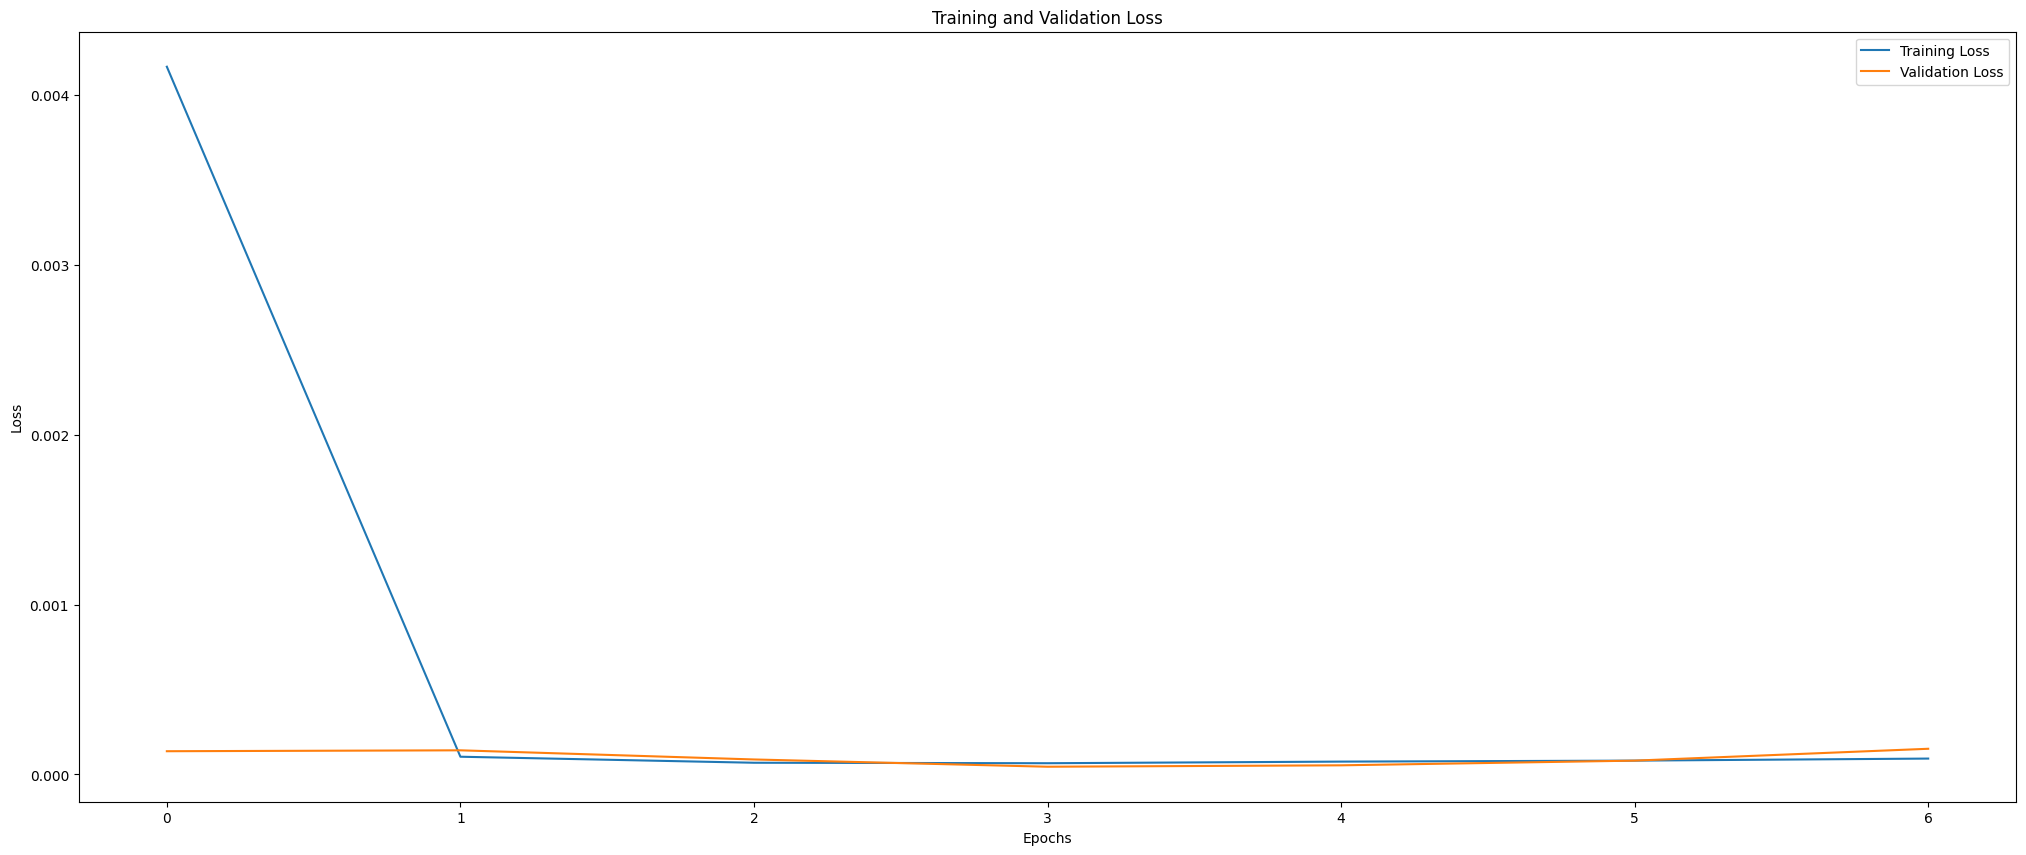

In [121]:
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 022 — Support step

A conversion step preparing arrays for plotting and aggregation.

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600, 3)]          0         
                                                                 
 conv1d (Conv1D)             (None, 599, 64)           448       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 299, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 19136)             0         
                                                                 
 dense (Dense)               (None, 60)                1148220   
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                             

### 023 — Support step

A targeted transformation aligning sample indices across windows.

In [25]:
collected_new_battery_data = collectData(new_battery_list)

### 024 — Scaling the story

To make features comparable, this step rescales current, temperature and voltage into the same numeric range. This is essential so the CNN learns patterns rather than numeric magnitudes.

In [26]:
normalized_new_battery_data = minMaxNormalization(collected_new_battery_data, min_feature_values, max_feature_values)

### 025 — Scaling the story

To make features comparable, this step rescales current, temperature and voltage into the same numeric range. This is essential so the CNN learns patterns rather than numeric magnitudes.

In [27]:
X_array_new_battery, y_array_new_battery = prepareData(normalized_new_battery_data)

### 026 — Inference on unseen batteries

This cell runs the trained CNN on new battery data to produce SoH trajectories. These predictions will later be cross-checked with measured SoH and explained with SHAP.

In [28]:
Y_pred = model.predict(X_array_new_battery)
Y_pred

36/36 [==============================] - 0s 10ms/step


array([[1.0011545 ],
       [0.9985623 ],
       [1.0042763 ],
       ...,
       [0.8495253 ],
       [0.85219383],
       [0.8486502 ]], dtype=float32)

### 027 — Visual checkpoint

This plotting cell transforms numbers into the figures similar to those shown in the paper (see Fig. 4–8). Inspect these plots to spot when temperature or voltage events line up with negative SHAP spikes.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


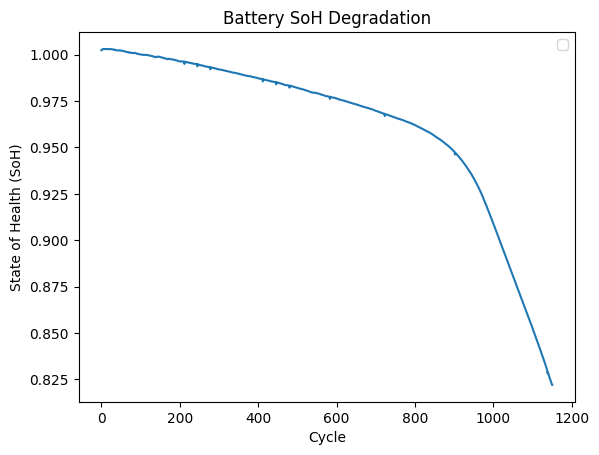

In [309]:
plt.plot(y_array_new_battery)
plt.legend()
plt.xlabel('Cycle')
plt.ylabel('State of Health (SoH)')
plt.title('Battery SoH Degradation')
plt.show()

### 028 — Visual checkpoint

This plotting cell transforms numbers into the figures similar to those shown in the paper (see Fig. 4–8). Inspect these plots to spot when temperature or voltage events line up with negative SHAP spikes.

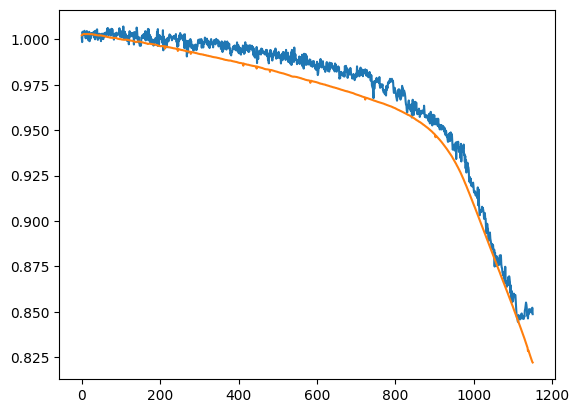

In [30]:
plt.plot(Y_pred)
plt.plot(y_array_new_battery)
plt.show()

### 029 — Visual checkpoint

This plotting cell transforms numbers into the figures similar to those shown in the paper (see Fig. 4–8). Inspect these plots to spot when temperature or voltage events line up with negative SHAP spikes.

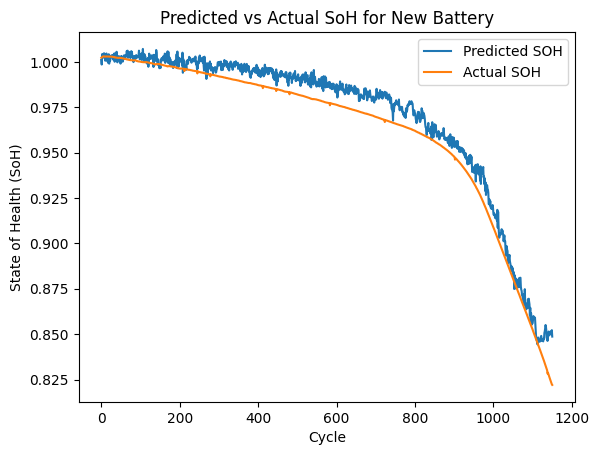

In [31]:
plt.plot(Y_pred, label='Predicted SOH')
plt.plot(y_array_new_battery, label='Actual SOH')
plt.legend()
plt.xlabel('Cycle')
plt.ylabel('State of Health (SoH)')
plt.title('Predicted vs Actual SoH for New Battery')
plt.show()

### 030 — Support step

A housekeeping operation ensuring array lengths match across results.

In [76]:
data[new_battery_min[0]]['cycle_life'][0][0]

541.0

### 031 — Scaling the story

To make features comparable, this step rescales current, temperature and voltage into the same numeric range. This is essential so the CNN learns patterns rather than numeric magnitudes.

In [79]:
collected_new_battery_data_max = collectData(new_battery_max)
normalized_new_battery_data_max = minMaxNormalization(collected_new_battery_data_max, min_feature_values, max_feature_values)
X_array_new_battery_max, y_array_new_battery_max = prepareData(normalized_new_battery_data_max)

### 032 — Scaling the story

To make features comparable, this step rescales current, temperature and voltage into the same numeric range. This is essential so the CNN learns patterns rather than numeric magnitudes.

In [80]:
collected_new_battery_data_min = collectData(new_battery_min)
normalized_new_battery_data_min = minMaxNormalization(collected_new_battery_data_min, min_feature_values, max_feature_values)
X_array_new_battery_min, y_array_new_battery_min = prepareData(normalized_new_battery_data_min)

### 033 — Support step

A small debugging or inspection step — useful during development.

In [50]:
tmp_soh = []
for battery in data_keys:
        if math.isnan(data[battery]['cycle_life'][0][0]):
            continue
        tmp_soh_cycle = []
        for cycle in range(1, int(data[battery]['cycle_life'][0][0]) - 1):
            if data[battery]['summary']['QD'][cycle] / data[battery]['summary']['QD'][0] <= 1.0:
                tmp_soh_cycle.append(data[battery]['summary']['QD'][cycle] / data[battery]['summary']['QD'][0])
        tmp_soh.append(tmp_soh_cycle)

### 034 — Visual checkpoint

This plotting cell transforms numbers into the figures similar to those shown in the paper (see Fig. 4–8). Inspect these plots to spot when temperature or voltage events line up with negative SHAP spikes.

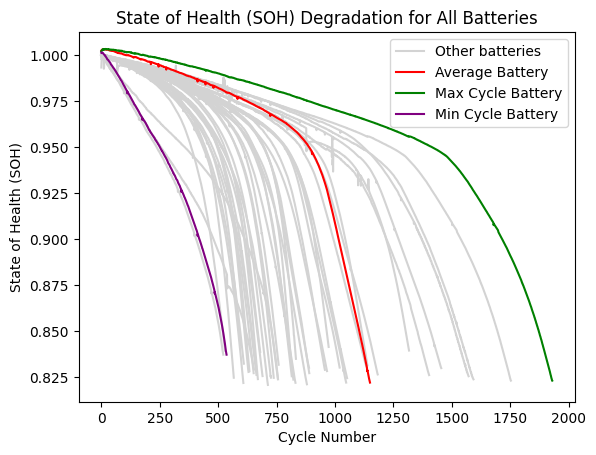

In [297]:
first_plot = True
for bat in tmp_soh:
    if first_plot:
        plt.plot(bat, label='Other batteries', c='lightgray')
        first_plot = False
    else:
        plt.plot(bat, c='lightgray')

plt.plot(y_array_new_battery, label='Average Battery', c='r')
plt.plot(y_array_new_battery_max, label='Max Cycle Battery', c='g')
plt.plot(y_array_new_battery_min, label='Min Cycle Battery', c='purple')

# Display the legend
plt.legend()

# Optionally, you can add titles and labels for clarity
plt.title('State of Health (SOH) Degradation for All Batteries')
plt.xlabel('Cycle Number')
plt.ylabel('State of Health (SOH)')

# Display the plot
plt.show()

## SHAP

### 035 — Visual checkpoint

This plotting cell transforms numbers into the figures similar to those shown in the paper (see Fig. 4–8). Inspect these plots to spot when temperature or voltage events line up with negative SHAP spikes.

In [274]:
import matplotlib.pyplot as pyplt

# pyplt.rcParams["figure.figsize"] = (25, 10)
plt.rcParams["figure.figsize"] = [6.4, 4.8]

### 036 — Visual checkpoint

This plotting cell transforms numbers into the figures similar to those shown in the paper (see Fig. 4–8). Inspect these plots to spot when temperature or voltage events line up with negative SHAP spikes.

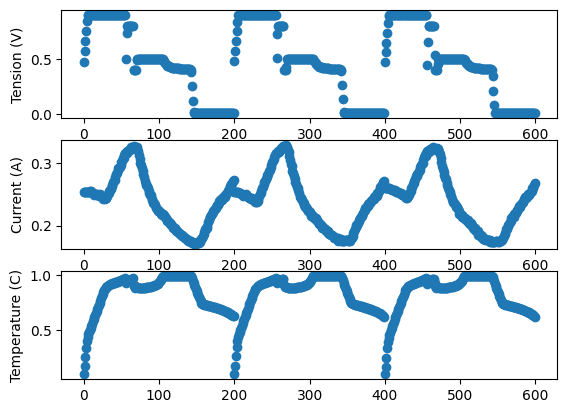

In [204]:
def plot_input_instance(input):
    # title = 'Input Data'
    mesure = ['Tension (V)', 'Current (A)', 'Temperature (C)']
    plt.figure()
    for j in range(3):
        Value = input[:, j]
        ax = plt.subplot(3, 1, j + 1)
        plt.ylabel(mesure[j])
        # print(heat_j)
        plt.scatter(range(600), Value)
    # plt.colorbar(orientation="horizontal")
    # plt.suptitle(title, fontsize=16)
    plt.show()


plot_input_instance(X_array[0])

### 037 — Assembling the explainer

We instantiate a SHAP explainer tailored to our model. This object will compute per-input contributions that explain why the CNN produced a given SoH estimate.

In [85]:
import shap
e = shap.GradientExplainer(model, X_train)
shapmap_avg = e.shap_values(X_array_new_battery)

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


### 038 — Computing local attributions

Local SHAP values are calculated here: each value tells how a specific time point and feature nudges the prediction up or down for that instance.

In [86]:
shapmap_max = e.shap_values(X_array_new_battery_max)
shapmap_min = e.shap_values(X_array_new_battery_min)

### 039 — Computing local attributions

Local SHAP values are calculated here: each value tells how a specific time point and feature nudges the prediction up or down for that instance.

In [291]:
def plot_shap_values_of_inputs(shmap,input,i):
    title = 'Contributions of values by color'
    mesure = ['Tension (V)','Current (A)','Temperature (C)']
    plt.figure()
    for j in range(3):
        Value = input[i][:,j]
        heat_j = shmap[i][:,j]
        heat_j = np.transpose(heat_j)
        ax = plt.subplot(3,1,j+1)
        plt.ylabel(mesure[j])
        # print(heat_j)
        plt.scatter(range(600),Value,c=heat_j)
    cbar = plt.colorbar(orientation="horizontal", pad=0.25)
    cbar.set_label('SHAP Value')
    # plt.colorbar(orientation="horizontal")
    # plt.suptitle(title,fontsize=16)
    plt.show()

### 040 — Computing local attributions

Local SHAP values are calculated here: each value tells how a specific time point and feature nudges the prediction up or down for that instance.

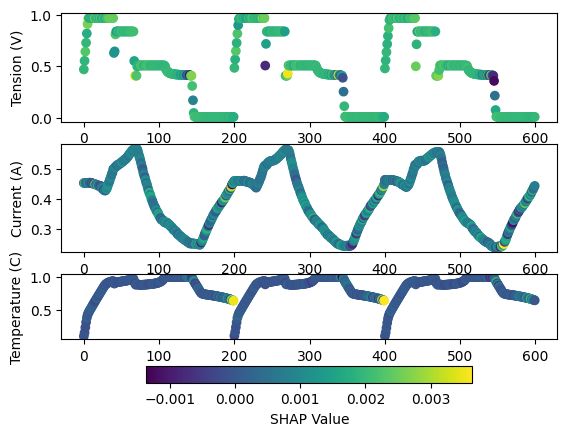

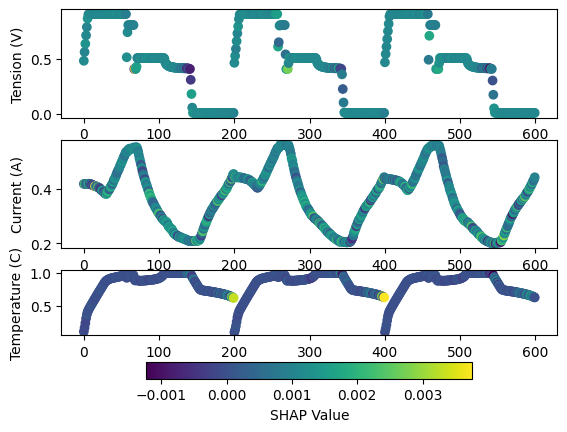

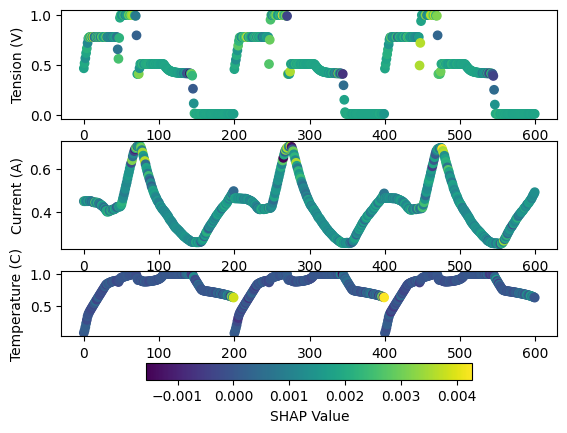

In [292]:
plot_shap_values_of_inputs(shapmap_avg, X_array_new_battery, 10)
plot_shap_values_of_inputs(shapmap_max, X_array_new_battery_max, 10)
plot_shap_values_of_inputs(shapmap_min, X_array_new_battery_min, 10)

### 041 — Aggregating SHAP into a global view

Local attributions are stitched together across sliding windows to form a continuous, temporal global attribution — revealing recurring patterns that drive long-term degradation.

In [112]:
def global_shap(shmap, ind):

    global_tension = shmap[0][:, 0]
    global_current = shmap[0][:, 1]
    global_temperature = shmap[0][:, 2]

    for i in range (1,ind):
        local_tension = shmap[i][:, 0]
        local_current = shmap[i][:, 1]
        local_temperature = shmap[i][:, 2]

        for j in range(0, 600):
            if j < 400:
                global_tension[200 * i + j] += local_tension[j]
                global_current[200 * i + j] += local_current[j]
                global_temperature[200 * i + j] += local_temperature[j]
            else:
                global_tension= np.append(global_tension, local_tension[j])
                global_current = np.append(global_current, local_current[j])
                global_temperature = np.append(global_temperature, local_temperature[j])

    global_feature = np.vstack((global_tension, global_current, global_temperature))

    return global_feature

### 042 — Aggregating SHAP into a global view

Local attributions are stitched together across sliding windows to form a continuous, temporal global attribution — revealing recurring patterns that drive long-term degradation.

In [262]:
global_feature_avg = global_shap(shapmap_avg, 10)
global_feature_max = global_shap(shapmap_max, 10)
global_feature_min = global_shap(shapmap_min, 10)

C:\Users\Admin\AppData\Local\Temp\ipykernel_27448\3581427102.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  global_tension[200 * i + j] += local_tension[j]
C:\Users\Admin\AppData\Local\Temp\ipykernel_27448\3581427102.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  global_current[200 * i + j] += local_current[j]
C:\Users\Admin\AppData\Local\Temp\ipykernel_27448\3581427102.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  global_temperature[200 * i + j]

### 043 — Aggregating SHAP into a global view

Local attributions are stitched together across sliding windows to form a continuous, temporal global attribution — revealing recurring patterns that drive long-term degradation.

In [320]:
def plot_global_shap(global_feature,input,start, end):
    # title = 'Contributions of each data point'
    mesure = ['Tension (V)','Current (A)','Temperature (C)']
    plt.figure()
    for j in range(3):
        Value = input[j][start:end]
        heat_j = global_feature[j]
        ax = plt.subplot(3,1,j+1)
        plt.ylabel(mesure[j])
        # print(len(Value))
        # print(len(heat_j))
        plt.scatter(range(end-start),Value,c=heat_j)
    cbar = plt.colorbar(orientation="horizontal", pad=0.25)
    cbar.set_label('SHAP Value')
    # plt.colorbar(orientation="horizontal")
    # plt.suptitle(title,fontsize=16)
    plt.show()

### 044 — Downsampling narrative

Raw sensor traces are dense and noisy; here we reduce temporal resolution to keep the cycle dynamics readable and the training affordable — preserving shape while trimming excess detail.

In [287]:
# Gather and downsample data for the validation battery
def collectFeatures(battery):
    tension_new_battery = [downsample_data(battery[0], i, 'V') for i in range(len(data[battery[0]]['cycles']))]
    current_new_battery = [downsample_data(battery[0], i, 'I') for i in range(len(data[battery[0]]['cycles']))]
    temperature_new_battery = [downsample_data(battery[0], i, 'T') for i in range(len(data[battery[0]]['cycles']))]

    # Convert lists to arrays and reshape
    tension_new_battery = np.array(tension_new_battery).reshape(-1)
    current_new_battery = np.array(current_new_battery).reshape(-1)
    temperature_new_battery = np.array(temperature_new_battery).reshape(-1)

    # Stack features vertically
    feature_new_battery = np.vstack((tension_new_battery, current_new_battery, temperature_new_battery))

    return feature_new_battery


### 045 — Support step

A conversion step preparing arrays for plotting and aggregation.

In [288]:
feature_new_battery = collectFeatures(new_battery_list)
feature_new_battery_max = collectFeatures(new_battery_max)
feature_new_battery_min = collectFeatures(new_battery_min)

### 046 — Aggregating SHAP into a global view

Local attributions are stitched together across sliding windows to form a continuous, temporal global attribution, revealing recurring patterns that drive long-term degradation.

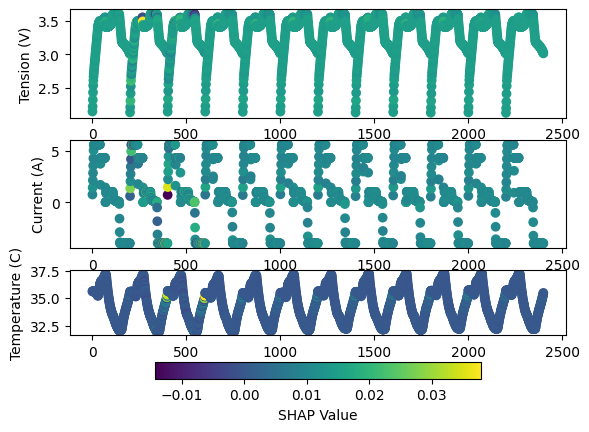

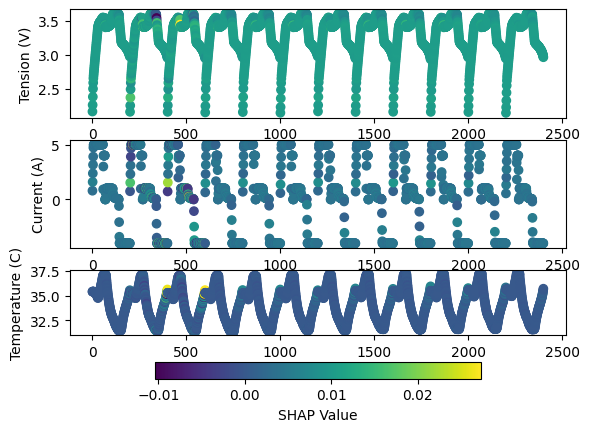

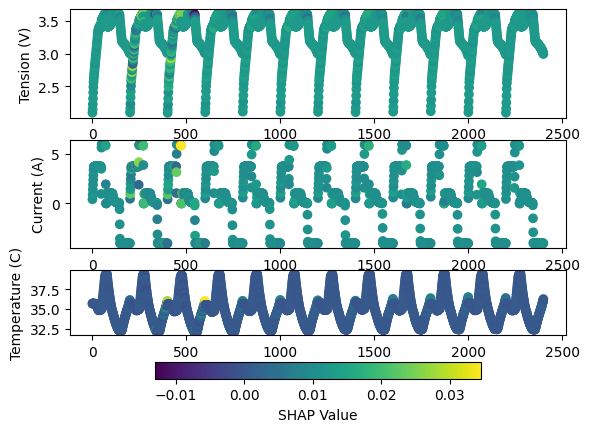

In [321]:
for i in range(2, 3):
  plot_global_shap(global_feature_avg, feature_new_battery, len(global_feature_avg[0]) * i, len(global_feature_avg[0]) * (i+1))
  plot_global_shap(global_feature_max, feature_new_battery_max, len(global_feature_max[0]) * i, len(global_feature_max[0]) * (i+1))
  plot_global_shap(global_feature_min, feature_new_battery_min, len(global_feature_min[0]) * i, len(global_feature_min[0]) * (i+1))